In [38]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path

density_mapping = {
    "apple": 0.78, "banana": 0.91, "bread": 0.18, "bun": 0.34, "doughnut": 0.31,
    "egg": 1.03, "fired_dough_twist": 0.58, "grape": 0.97, "lemon": 0.96, "litchi": 1.00,
    "mango": 1.07, "mooncake": 0.96, "orange": 0.90, "pear": 1.02, "peach": 0.96,
    "plum": 1.01, "qiwi": 0.97, "sachima": 0.22, "tomato": 0.98
}

energy_mapping = {
    "apple": 0.52, "banana": 0.89, "bread": 3.15, "bun": 2.23, "doughnut": 4.34,
    "egg": 1.43, "fired_dough_twist": 24.16, "grape": 0.69, "lemon": 0.29, "litchi": 0.66,
    "mango": 0.60, "mooncake": 18.83, "orange": 0.63, "pear": 0.39, "peach": 0.57,
    "plum": 0.46, "qiwi": 0.61, "sachima": 21.45, "tomato": 0.27
}

shape_mapping = {
    "apple": "ellipsoid", "banana": "irregular", "bread": "column", "bun": "irregular",
    "doughnut": "irregular", "egg": "ellipsoid", "fired_dough_twist": "irregular",
    "grape": "irregular", "lemon": "ellipsoid", "mango": "irregular", "litchi": "irregular",
    "mooncake": "column", "orange": "ellipsoid", "pear": "irregular", "peach": "ellipsoid",
    "plum": "ellipsoid", "qiwi": "ellipsoid", "sachima": "column", "tomato": "ellipsoid"
}


In [39]:
def load_yolo_predictions(pred_file, class_names):
    
    bboxes = []
    with open(pred_file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            parts = line.strip().split()
            class_idx = int(parts[0])
            bbox = tuple(map(float, parts[1:5]))  
            class_name = class_names[class_idx]
            bboxes.append({'class': class_name, 'bbox': bbox})
    return bboxes


In [40]:
def crop_from_image(image_path, bbox):
    
    image = cv2.imread(str(image_path))
    h, w = image.shape[:2]

    x_center, y_center, width_box, height_box = bbox
    x_center *= w
    y_center *= h
    width_box *= w
    height_box *= h

    x1 = int(x_center - width_box / 2)
    y1 = int(y_center - height_box / 2)
    x2 = int(x_center + width_box / 2)
    y2 = int(y_center + height_box / 2)

    cropped = image[max(0, y1):min(h, y2), max(0, x1):min(w, x2)]

    return cropped


In [41]:
def grabcut_segmentation(crop_img, iter_count=5):
    
    mask = np.zeros(crop_img.shape[:2], np.uint8)

    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)

    h, w = crop_img.shape[:2]
    rect = (1, 1, w-2, h-2)

    cv2.grabCut(crop_img, mask, rect, bgdModel, fgdModel, iter_count, cv2.GC_INIT_WITH_RECT)

    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    segmented_img = crop_img * mask2[:, :, np.newaxis]

    return segmented_img, mask2


In [42]:
def compute_alpha(crop_coin):
    
    real_coin_diameter_mm = 25  
    h, w = crop_coin.shape[:2]
    pixel_diameter = max(h, w)  
    alpha = real_coin_diameter_mm / pixel_diameter
    return alpha

In [43]:
def estimate_volume(mask_side, alpha_side, alpha_top, shape_type):
    

    beta = 1.0  

    H_s, W_s = mask_side.shape
    Lk = np.sum(mask_side == 1, axis=1) 
    L_max = np.max(Lk)

    if shape_type == "ellipsoid":
        volume = beta * (np.pi / 4) * (alpha_side ** 3) * np.sum(Lk ** 2)
    elif shape_type == "column":
        surface_area_top = np.sum(mask_side == 1)  
        volume = beta * (alpha_top ** 2) * (alpha_side * H_s) * surface_area_top
    elif shape_type == "irregular":
        surface_area_top = np.sum(mask_side == 1)
        volume = beta * (alpha_top ** 2) * (alpha_side) * np.sum((Lk / L_max) ** 2) * surface_area_top
    else:
        raise ValueError(f"Unknown shape type: {shape_type}")

    return volume


In [44]:
def estimate_mass_and_calories(volume_mm3, food_class, density_mapping, energy_mapping):
    
    volume_cm3 = volume_mm3 / 1000  
    density = density_mapping.get(food_class, 1.0)  
    mass_g = volume_cm3 * density

    energy_per_g = energy_mapping.get(food_class, 1.0)
    calories = mass_g * energy_per_g

    return mass_g, calories


In [45]:
def process_single_image(top_image_path, side_image_path, 
                          top_label_path, side_label_path, 
                          class_names, density_mapping, energy_mapping):
    

    top_preds = load_yolo_predictions(top_label_path, class_names)
    side_preds = load_yolo_predictions(side_label_path, class_names)

    food_bbox_top = None
    coin_bbox_top = None
    for pred in top_preds:
        if pred['class'] == 'coin':
            coin_bbox_top = pred['bbox']
        else:
            food_bbox_top = pred['bbox']

    food_bbox_side = None
    coin_bbox_side = None
    for pred in side_preds:
        if pred['class'] == 'coin':
            coin_bbox_side = pred['bbox']
        else:
            food_bbox_side = pred['bbox']

    if food_bbox_top is None or coin_bbox_top is None or food_bbox_side is None or coin_bbox_side is None:
        print(f"[Skipping] Missing food or coin bbox for {top_image_path.name}")
        return None

    food_crop_top = crop_from_image(top_image_path, food_bbox_top)
    coin_crop_top = crop_from_image(top_image_path, coin_bbox_top)
    food_crop_side = crop_from_image(side_image_path, food_bbox_side)
    coin_crop_side = crop_from_image(side_image_path, coin_bbox_side)

    _, food_mask_top = grabcut_segmentation(food_crop_top)
    _, food_mask_side = grabcut_segmentation(food_crop_side)

    alpha_top = compute_alpha(coin_crop_top)
    alpha_side = compute_alpha(coin_crop_side)

    food_class = None
    for pred in side_preds:
        if pred['class'] != 'coin':
            food_class = pred['class']
            break

    if food_class is None:
        food_class = "unknown"

    shape_type = shape_mapping.get(food_class, "ellipsoid")

    volume_mm3 = estimate_volume(food_mask_side, alpha_side, alpha_top, shape_type)

    mass_g, calories = estimate_mass_and_calories(volume_mm3, food_class, density_mapping, energy_mapping)

    return {
        "image": top_image_path.name,
        "class": food_class,
        "volume_mm3": volume_mm3,
        "mass_g": mass_g,
        "calories": calories
    }


In [46]:
def process_all_images(top_images_dir, side_images_dir, 
                        top_labels_dir, side_labels_dir, 
                        class_names, density_mapping, energy_mapping):

    results = []
    
    top_image_paths = list(Path(top_images_dir).glob("*.jpg"))

    print(f"Found {len(top_image_paths)}  images.")

    for top_img_path in top_image_paths:
        img_id = top_img_path.stem.replace('T', 'S') 
        side_img_path = Path(side_images_dir) / (img_id + ".jpg")

        top_label_path = Path(top_labels_dir) / (top_img_path.stem + ".txt")
        side_label_path = Path(side_labels_dir) / (img_id + ".txt")

        if not side_img_path.exists() or not top_label_path.exists() or not side_label_path.exists():
            print(f"[Skipping] Missing side image or label for {top_img_path.name}")
            continue

        result = process_single_image(
            top_img_path, side_img_path,
            top_label_path, side_label_path,
            class_names, density_mapping, energy_mapping
        )

        if result:
            results.append(result)

    results_df = pd.DataFrame(results)
    return results_df

In [47]:
top_images_dir = 'ecust_dataset/images/val'
side_images_dir = 'ecust_dataset/images/val'
top_labels_dir = 'runs/detect/ecust_test_output/labels'
side_labels_dir = 'runs/detect/ecust_test_output/labels'

class_names = [
    "apple", "banana", "bread", "bun", "doughnut", "egg", "fired_dough_twist",
    "grape", "lemon", "litchi", "mango", "mooncake", "orange", "pear", "peach",
    "plum", "qiwi", "sachima", "tomato", "coin"
]

results_df = process_all_images(top_images_dir, side_images_dir, top_labels_dir, side_labels_dir,
                                class_names, density_mapping, energy_mapping)

results_df.to_csv('ecust_yolo_final_volume_calorie_predictions.csv', index=False)
print("Results saved to ecust_yolo_final_volume_calorie_predictions.csv")

display(results_df.head())


Found 623  images.
[Skipping] Missing side image or label for apple002T(1).jpg
[Skipping] Missing side image or label for apple002T(4).jpg
[Skipping] Missing side image or label for apple002T(5).jpg
[Skipping] Missing side image or label for apple003T(1).jpg
[Skipping] Missing side image or label for apple003T(2).jpg
[Skipping] Missing side image or label for apple004T(2).jpg
[Skipping] Missing side image or label for apple005T(5).jpg
[Skipping] Missing side image or label for apple006T(1).jpg
[Skipping] Missing side image or label for apple007T(3).jpg
[Skipping] Missing side image or label for apple009T(1).jpg
[Skipping] Missing side image or label for apple011T(1).jpg
[Skipping] Missing side image or label for apple012T(4).jpg
[Skipping] Missing side image or label for apple012T(5).jpg
[Skipping] Missing side image or label for apple013T(6).jpg
[Skipping] Missing side image or label for apple014T(4).jpg
[Skipping] Missing side image or label for apple014T(5).jpg
[Skipping] Missing si

C:\Users\Sanket\AppData\Local\Temp\ipykernel_24000\1840748301.py:22: RuntimeWarning: invalid value encountered in divide
  volume = beta * (alpha_top ** 2) * (alpha_side) * np.sum((Lk / L_max) ** 2) * surface_area_top


[Skipping] Missing side image or label for banana010T(6).jpg
[Skipping] Missing side image or label for banana010T(7).jpg
[Skipping] Missing side image or label for bread001T(1).jpg
[Skipping] Missing side image or label for bread001T(2).jpg
[Skipping] Missing side image or label for bread001T(5).jpg
[Skipping] Missing side image or label for bread001T(7).jpg
[Skipping] Missing side image or label for bread002T(2).jpg
[Skipping] Missing side image or label for bun001T(7).jpg
[Skipping] Missing side image or label for bun003T(3).jpg
[Skipping] Missing food or coin bbox for doughnut001S(3).jpg
[Skipping] Missing side image or label for doughnut002T(2).jpg
[Skipping] Missing side image or label for doughnut004T(10).jpg
[Skipping] Missing side image or label for doughnut004T(15).jpg
[Skipping] Missing side image or label for doughnut004T(4).jpg
[Skipping] Missing side image or label for doughnut005T(2).jpg
[Skipping] Missing side image or label for doughnut005T(4).jpg
[Skipping] Missing si

,image,class,volume_mm3,mass_g,calories
0,apple002S(2).jpg,apple,256502.795903,200.072181,104.037534
1,apple002S(3).jpg,apple,188355.941432,146.917634,76.397170
2,apple002S(7).jpg,apple,155589.940520,121.360154,63.107280
3,apple002T(2).jpg,apple,261750.508950,204.165397,106.166006
4,apple003S(3).jpg,apple,211052.864207,164.621234,85.603042


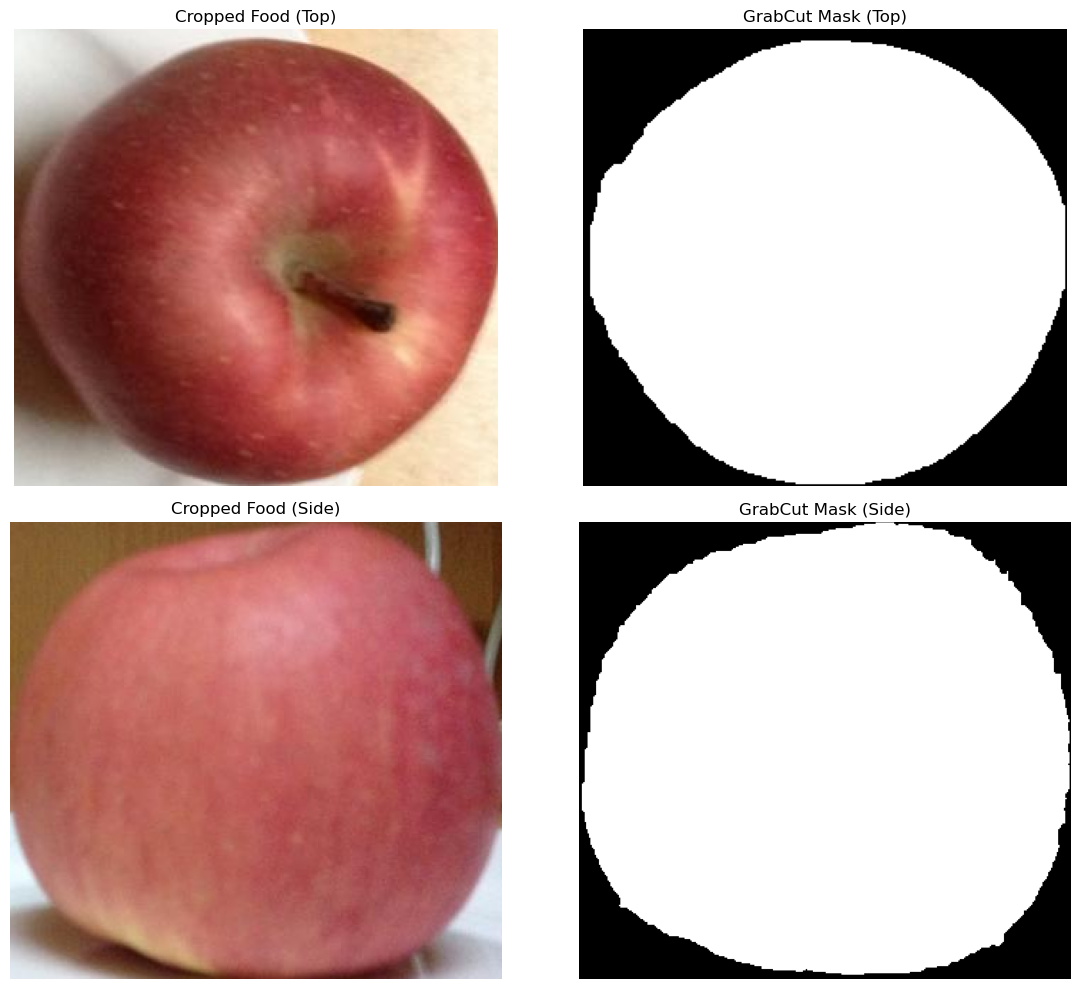

In [51]:
top_image_path = Path('ecust_dataset/images/val/apple004T(2).jpg')
side_image_path = Path('ecust_dataset/images/val/apple005S(6).jpg')
top_label_path = Path('runs/detect/ecust_test_output/labels/apple004T(2).txt')
side_label_path = Path('runs/detect/ecust_test_output/labels/apple005S(6).txt')

top_preds = load_yolo_predictions(top_label_path, class_names)
side_preds = load_yolo_predictions(side_label_path, class_names)

food_bbox_top = [pred['bbox'] for pred in top_preds if pred['class'] != 'coin'][0]
coin_bbox_top = [pred['bbox'] for pred in top_preds if pred['class'] == 'coin'][0]
food_bbox_side = [pred['bbox'] for pred in side_preds if pred['class'] != 'coin'][0]
coin_bbox_side = [pred['bbox'] for pred in side_preds if pred['class'] == 'coin'][0]

food_crop_top = crop_from_image(top_image_path, food_bbox_top)
coin_crop_top = crop_from_image(top_image_path, coin_bbox_top)
food_crop_side = crop_from_image(side_image_path, food_bbox_side)
coin_crop_side = crop_from_image(side_image_path, coin_bbox_side)

segmented_top, mask_top = grabcut_segmentation(food_crop_top)
segmented_side, mask_side = grabcut_segmentation(food_crop_side)

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0,0].imshow(cv2.cvtColor(food_crop_top, cv2.COLOR_BGR2RGB))
axs[0,0].set_title('Cropped Food (Top)')
axs[0,0].axis('off')

axs[0,1].imshow(mask_top, cmap='gray')
axs[0,1].set_title('GrabCut Mask (Top)')
axs[0,1].axis('off')

axs[1,0].imshow(cv2.cvtColor(food_crop_side, cv2.COLOR_BGR2RGB))
axs[1,0].set_title('Cropped Food (Side)')
axs[1,0].axis('off')

axs[1,1].imshow(mask_side, cmap='gray')
axs[1,1].set_title('GrabCut Mask (Side)')
axs[1,1].axis('off')

plt.tight_layout()
plt.show()